In [1]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.sql import Row
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import *

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
2,None,pyspark3,idle,,,✔


SparkSession available as 'spark'.


In [2]:
def csvParse(s):
    import csv
    import io
    sio = io.StringIO(s)
    value = csv.reader(sio).__next__()
    sio.close()
    return value

inspections = sc.textFile('/Food_Inspections1.csv').map(csvParse)

In [3]:
inspections.take(1)

[['413707', 'LUNA PARK INC', 'LUNA PARK  DAY CARE', '2049789', "Children's Services Facility", 'Risk 1 (High)', '3250 W FOSTER AVE ', 'CHICAGO', 'IL', '60625', '09/21/2010', 'License-Task Force', 'Fail', '24. DISH WASHING FACILITIES: PROPERLY DESIGNED, CONSTRUCTED, MAINTAINED, INSTALLED, LOCATED AND OPERATED - Comments: All dishwashing machines must be of a type that complies with all requirements of the plumbing section of the Municipal Code of Chicago and Rules and Regulation of the Board of Health. OBSEVERD THE 3 COMPARTMENT SINK BACKING UP INTO THE 1ST AND 2ND COMPARTMENT WITH CLEAR WATER AND SLOWLY DRAINING OUT. INST NEED HAVE IT REPAIR. CITATION ISSUED, SERIOUS VIOLATION 7-38-030 H000062369-10 COURT DATE 10-28-10 TIME 1 P.M. ROOM 107 400 W. SURPERIOR. | 36. LIGHTING: REQUIRED MINIMUM FOOT-CANDLES OF LIGHT PROVIDED, FIXTURES SHIELDED - Comments: Shielding to protect against broken glass falling into food shall be provided for all artificial lighting sources in preparation, service

In [4]:
schema = StructType([StructField("id", IntegerType(), False), 
                     StructField("name", StringType(), False), 
                     StructField("results", StringType(), False), 
                     StructField("violations", StringType(), True)])

df = spark.createDataFrame(inspections.map(lambda l: (int(l[0]), l[1], l[12], l[13])) , schema)
df.createOrReplaceTempView('CountResults')

In [5]:
df.show(5)

+------+--------------------+-------+--------------------+
|    id|                name|results|          violations|
+------+--------------------+-------+--------------------+
|413707|       LUNA PARK INC|   Fail|24. DISH WASHING ...|
|391234|       CAFE SELMARIE|   Fail|2. FACILITIES TO ...|
|413751|          MANCHU WOK|   Pass|33. FOOD AND NON-...|
|413708|BENCHMARK HOSPITA...|   Pass|                    |
|413722|           JJ BURGER|   Pass|                    |
+------+--------------------+-------+--------------------+
only showing top 5 rows

In [6]:
df.select('results').distinct().show()

+--------------------+
|             results|
+--------------------+
|                Fail|
|Business Not Located|
|  Pass w/ Conditions|
|     Out of Business|
|                Pass|
+--------------------+

In [7]:
%%sql -o count_results_df
SELECT results, COUNT(results) AS cnt FROM CountResults GROUP BY results

Output()

(-1.112537354338346,
 1.1005970237733604,
 -1.1077229124950763,
 1.1033458002044265)

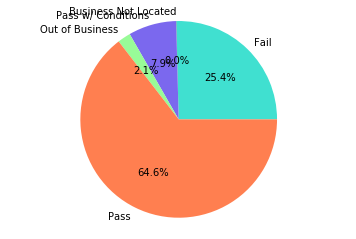

In [8]:
%%local
%matplotlib inline
import matplotlib.pyplot as plt


labels = count_results_df['results']
sizes = count_results_df['cnt']
colors = ['turquoise', 'seagreen', 'mediumslateblue', 'palegreen', 'coral']
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
plt.axis('equal')

In [9]:
def labelForResults(s):
    if s == 'Fail':
        return 0.0
    elif s == 'Pass w/ Conditions' or s == 'Pass':
        return 1.0
    else:
        return -1.0
label = UserDefinedFunction(labelForResults, DoubleType())
labeledData = df.select(label(df.results).alias('label'), df.violations).where('label >= 0')

In [10]:
labeledData.take(1)

[Row(label=0.0, violations='24. DISH WASHING FACILITIES: PROPERLY DESIGNED, CONSTRUCTED, MAINTAINED, INSTALLED, LOCATED AND OPERATED - Comments: All dishwashing machines must be of a type that complies with all requirements of the plumbing section of the Municipal Code of Chicago and Rules and Regulation of the Board of Health. OBSEVERD THE 3 COMPARTMENT SINK BACKING UP INTO THE 1ST AND 2ND COMPARTMENT WITH CLEAR WATER AND SLOWLY DRAINING OUT. INST NEED HAVE IT REPAIR. CITATION ISSUED, SERIOUS VIOLATION 7-38-030 H000062369-10 COURT DATE 10-28-10 TIME 1 P.M. ROOM 107 400 W. SURPERIOR. | 36. LIGHTING: REQUIRED MINIMUM FOOT-CANDLES OF LIGHT PROVIDED, FIXTURES SHIELDED - Comments: Shielding to protect against broken glass falling into food shall be provided for all artificial lighting sources in preparation, service, and display facilities. LIGHT SHIELD ARE MISSING UNDER HOOD OF  COOKING EQUIPMENT AND NEED TO REPLACE LIGHT UNDER UNIT. 4 LIGHTS ARE OUT IN THE REAR CHILDREN AREA,IN THE KINDE

In [11]:
tokenizer = Tokenizer(inputCol="violations", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.01)
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])

model = pipeline.fit(labeledData)
model

PipelineModel_41a7a46ffe5fef47b904

In [12]:
testData = sc.textFile('/Food_Inspections2.csv')\
             .map(csvParse) \
             .map(lambda l: (int(l[0]), l[1], l[12], l[13]))
testDf = spark.createDataFrame(testData, schema).where("results = 'Fail' OR results = 'Pass' OR results = 'Pass w/ Conditions'")
predictionsDf = model.transform(testDf)
predictionsDf.createOrReplaceTempView('Predictions')
predictionsDf.columns

['id', 'name', 'results', 'violations', 'words', 'features', 'rawPrediction', 'probability', 'prediction']

In [13]:
predictionsDf.take(2)

[Row(id=580320, name="COUSIN'S GRILL", results='Fail', violations='37. TOILET ROOM DOORS SELF CLOSING: DRESSING ROOMS WITH LOCKERS PROVIDED: COMPLETE SEPARATION FROM LIVING/SLEEPING QUARTERS - Comments: INSTRUCTED TO FIX BROKEN SELF CLOSING DEVICE AT WASHROOM DOOR. | 40. REFRIGERATION AND METAL STEM THERMOMETERS PROVIDED AND CONSPICUOUS - Comments: All food establishments that display, prepare, or store potentially hazardous foods shall have calibrated metal stem thermometers, provided and conspicuous, for refrigerated and hot food units.  INSTRUCTED TO PROVIDE THERMOMETTER VISIBLE INSIDE ALL COOLERS. | 36. LIGHTING: REQUIRED MINIMUM FOOT-CANDLES OF LIGHT PROVIDED, FIXTURES SHIELDED - Comments: Shielding to protect against broken glass falling into food shall be provided for all artificial lighting sources in preparation, service, and display facilities.  LIGHTBULBS MUST BE SHIELDED INSIDE HOT HOLDING DISPLAY UNIT OR PROVIDE SHATTERFROOFED LIGHTBULB.   | 18. NO EVIDENCE OF RODENT OR IN

In [14]:
numSuccesses = predictionsDf.where("""(prediction = 0 AND results = 'Fail') OR 
                                      (prediction = 1 AND (results = 'Pass' OR 
                                                           results = 'Pass w/ Conditions'))""").count()
numInspections = predictionsDf.count()

print("There were", numInspections, "inspections and there were", numSuccesses, "successful predictions")
print("This is a", str((float(numSuccesses) / float(numInspections)) * 100) + "%", "success rate")

There were 9315 inspections and there were 8110 successful predictions
This is a 87.06387546967257% success rate

In [15]:
%%sql -q -o true_positive
SELECT count(*) AS cnt FROM Predictions WHERE prediction = 0 AND results = 'Fail'

In [16]:
%%sql -q -o false_positive
SELECT count(*) AS cnt FROM Predictions WHERE prediction = 0 AND (results = 'Pass' OR results = 'Pass w/ Conditions')

In [17]:
%%sql -q -o true_negative
SELECT count(*) AS cnt FROM Predictions WHERE prediction = 1 AND results = 'Fail'

In [ ]:
%%sql -q -o false_negative
SELECT count(*) AS cnt FROM Predictions WHERE prediction = 1 AND (results = 'Pass' OR results = 'Pass w/ Conditions')

In [ ]:
%%local
%matplotlib inline
import matplotlib.pyplot as plt

labels = ['True positive', 'False positive', 'True negative', 'False negative']
sizes = [true_positive['cnt'], false_positive['cnt'], false_negative['cnt'], true_negative['cnt']]
colors = ['turquoise', 'seagreen', 'mediumslateblue', 'palegreen', 'coral']
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
plt.axis('equal')